In [1]:
import trackhhl.toy.simple_generator as toy
import trackhhl.event_model.q_event_model as em
import numpy as np
import itertools
import copy
from dwave.samplers import SimulatedAnnealingSampler
import dimod
import psutil
import time
from scipy.sparse import lil_matrix, csc_matrix, block_diag
from dwave.system import DWaveSampler, EmbeddingComposite
import tracemalloc




In [29]:
def generate_detector_hits(n_modules, n_particles):
    LX = float("+inf")
    LY = float("+inf")
    Z_SPACING = 1.0
    THETA_MAX = np.pi / 6

    # Create detector geometry with fixed lx, ly, and z_spacing
    detector = toy.SimpleDetectorGeometry(
        module_id=list(range(n_modules)),
        lx=[LX] * n_modules,
        ly=[LY] * n_modules,
        z=[i + Z_SPACING for i in range(n_modules)]  # Match original behavior by using i + Z_SPACING
    )

    # Create a generator for particles
    generator = toy.SimpleGenerator(
        detector_geometry=detector,
        theta_max=THETA_MAX
    )

    # Generate an event with the specified number of particles
    event = generator.generate_event(n_particles)

    # Return the hits generated by the event
    return event.hits
generate_detector_hits(5,2)

[Hit(hit_id=0, x=-0.062213245692465925, y=-0.11523970804604995, z=1.0, module_id=0, track_id=0),
 Hit(hit_id=5, x=-0.3859094316356624, y=-0.20118277037574897, z=1.0, module_id=0, track_id=1),
 Hit(hit_id=1, x=-0.12442649138493185, y=-0.2304794160920999, z=2.0, module_id=1, track_id=0),
 Hit(hit_id=6, x=-0.7718188632713248, y=-0.40236554075149794, z=2.0, module_id=1, track_id=1),
 Hit(hit_id=2, x=-0.18663973707739775, y=-0.3457191241381498, z=3.0, module_id=2, track_id=0),
 Hit(hit_id=7, x=-1.1577282949069871, y=-0.6035483111272469, z=3.0, module_id=2, track_id=1),
 Hit(hit_id=3, x=-0.2488529827698637, y=-0.4609588321841998, z=4.0, module_id=3, track_id=0),
 Hit(hit_id=8, x=-1.5436377265426495, y=-0.8047310815029959, z=4.0, module_id=3, track_id=1),
 Hit(hit_id=4, x=-0.3110662284623296, y=-0.5761985402302497, z=5.0, module_id=4, track_id=0),
 Hit(hit_id=9, x=-1.929547158178312, y=-1.005913851878745, z=5.0, module_id=4, track_id=1)]

In [32]:
params = {
    'alpha': 1.0,
    'beta': 1.0,
    'lambda': 100.0,} 

def generate_hamiltonian_optimized(event, params):
    lambda_val = params.get('lambda')
    alpha = params.get('alpha')
    beta = params.get('beta')

    modules = sorted(event.modules, key=lambda module: module.z)

    
    segments = [
        em.segment(from_hit, to_hit)
        for idx in range(len(modules) - 1)
        for from_hit, to_hit in itertools.product(modules[idx].hits, modules[idx + 1].hits)
    ]

    N = len(segments)  

    #initialize sparse block matrices for effviciency
    A_ang_blocks = []
    A_bif_blocks = []
    A_inh_blocks = []
    b = np.zeros(N)

    #total Hamiltonian into smaller blocks->> better for memory
    block_size = 500  
    num_blocks = (N + block_size - 1) // block_size  

    for block_idx in range(num_blocks):
        start_idx = block_idx * block_size
        end_idx = min(start_idx + block_size, N)

        #lil_matrix for each block
        A_ang_block = lil_matrix((end_idx - start_idx, end_idx - start_idx), dtype=np.float32)
        A_bif_block = lil_matrix((end_idx - start_idx, end_idx - start_idx), dtype=np.float32)
        A_inh_block = lil_matrix((end_idx - start_idx, end_idx - start_idx), dtype=np.float32)

        #filling of papricas
        for i in range(start_idx, end_idx):
            seg_i = segments[i]
            vect_i = seg_i.to_vect()
            norm_i = np.linalg.norm(vect_i)

            for j in range(i + 1, end_idx):  #
                seg_j = segments[j]
                vect_j = seg_j.to_vect()
                norm_j = np.linalg.norm(vect_j)

                cosine = np.dot(vect_i, vect_j) / (norm_i * norm_j)
                if np.abs(cosine - 1) < 1e-9:
                    A_ang_block[i - start_idx, j - start_idx] = 1
                    A_ang_block[j - start_idx, i - start_idx] = 1  # Symmetry with positive sign

                if seg_i.from_hit == seg_j.from_hit and seg_i.to_hit != seg_j.to_hit:
                    A_bif_block[i - start_idx, j - start_idx] = -alpha
                    A_bif_block[j - start_idx, i - start_idx] = -alpha  # Symmetry with negative sign

                if seg_i.from_hit != seg_j.from_hit and seg_i.to_hit == seg_j.to_hit:
                    A_bif_block[i - start_idx, j - start_idx] = -alpha
                    A_bif_block[j - start_idx, i - start_idx] = -alpha  # Symmetry with negative sign

                s_ab = int(seg_i.from_hit.module_id == 1 and seg_j.to_hit.module_id == 1)
                if s_ab > 0:
                    A_inh_block[i - start_idx, j - start_idx] = beta * s_ab * s_ab
                    A_inh_block[j - start_idx, i - start_idx] = beta * s_ab * s_ab  # Symmetry with positive sign

        A_ang_blocks.append(A_ang_block)
        A_bif_blocks.append(A_bif_block)
        A_inh_blocks.append(A_inh_block)

    # combine withblock diagonal
    A_ang = block_diag(A_ang_blocks, format='csc')
    A_bif = block_diag(A_bif_blocks, format='csc')
    A_inh = block_diag(A_inh_blocks, format='csc')

    A = -1 * (A_ang + A_bif + A_inh)

    return A, b, segments
generate_hamiltonian_optimized(event, params)


(<16x16 sparse matrix of type '<class 'numpy.float32'>'
 	with 56 stored elements in Compressed Sparse Column format>,
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 [segment(from_hit=Hit(hit_id=0, x=-0.24429214154817214, y=-0.22964211367630655, z=1.0, module_id=0, track_id=0), to_hit=Hit(hit_id=1, x=-0.4885842830963443, y=-0.4592842273526131, z=2.0, module_id=1, track_id=0), truth=True),
  segment(from_hit=Hit(hit_id=0, x=-0.24429214154817214, y=-0.22964211367630655, z=1.0, module_id=0, track_id=0), to_hit=Hit(hit_id=6, x=-0.4489076521867487, y=0.9119461810704655, z=2.0, module_id=1, track_id=1), truth=False),
  segment(from_hit=Hit(hit_id=5, x=-0.22445382609337436, y=0.4559730905352328, z=1.0, module_id=0, track_id=1), to_hit=Hit(hit_id=1, x=-0.4885842830963443, y=-0.4592842273526131, z=2.0, module_id=1, track_id=0), truth=False),
  segment(from_hit=Hit(hit_id=5, x=-0.22445382609337436, y=0.4559730905352328, z=1.0, module_id=0, track_id=1), to_hit=Hit(hit_

In [4]:
import dimod
import psutil
import time
from scipy.sparse import csc_matrix

def qubosolver(A, b):

    #performance measurement
    process = psutil.Process()
    start_memory = process.memory_info().rss / (1024 ** 2)  # Memory in MB
    start_time = time.time()

    #Keep A sparse
    A = csc_matrix(A)

    bqm = dimod.BinaryQuadraticModel.empty(dimod.BINARY)

    #vectors for efficiency 
    bqm.add_variables_from({i: b[i] for i in range(len(b))})

    row, col = A.nonzero()  
    for i, j in zip(row, col):
        if i != j:  
            bqm.add_interaction(i, j, A[i, j])

    sampler = SimulatedAnnealingSampler()
    response = sampler.sample(bqm, num_reads=100)

    best_sample = response.first.sample
    sol_sample = np.fromiter(best_sample.values(), dtype=int)  

    end_memory = process.memory_info().rss / (1024 ** 2) 
    end_time = time.time()

   
    memory_used = end_memory - start_memory
    time_taken = end_time - start_time

    print(f"Solution:{sol_sample}")
    print(f"Memory {memory_used:.2f} MB")
    print(f"Time {time_taken:.6f} seconds")

    return sol_sample




In [35]:
def qubosolverQA(A, b):
    # Start tracing memory allocations
    tracemalloc.start()
    start_time = time.time()

    # Keep A sparse
    A = csc_matrix(A)

    bqm = dimod.BinaryQuadraticModel.empty(dimod.BINARY)
    bqm.add_variables_from({i: b[i] for i in range(len(b))})

    row, col = A.nonzero()
    for i, j in zip(row, col):
        if i != j:
            bqm.add_interaction(i, j, A[i, j])

    # Use D-Wave's quantum sampler
    sampler = EmbeddingComposite(DWaveSampler(token='DEV-2df6769d96a5ddaec4b4e037d3a7a92833582e9c'))
    response = sampler.sample(bqm, num_reads=100)

    best_sample = response.first.sample
    sol_sample = np.fromiter(best_sample.values(), dtype=int)

    end_time = time.time()
    # Get the current and peak memory usage
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    memory_used = peak / (1024 ** 2)
    time_taken = end_time - start_time

    print(f"Solution: {sol_sample}")
    print(f"Peak Memory Used: {memory_used:.2f} MB")
    print(f"Time Taken: {time_taken:.6f} seconds")

    return sol_sample #, memory_used, time_taken

qubosolverQA(A, b)


Solution: [1 0 0 1 1 0 0 1 1 0 0 1 1 0 0 1]
Peak Memory Used: 48.91 MB
Time Taken: 9.197080 seconds


(array([1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1]),
 48.909488677978516,
 9.19707989692688)

In [6]:
from dwave.system import LeapHybridSampler  # Import D-Wave hybrid sampler
import os

os.environ['DWAVE_API_TOKEN'] = 'DEV-031741f1792495e220d4d55aeb72ab7961cc16cd'

def qubosolverHr(A, b):
    # Performance measurement
    process = psutil.Process()
    start_memory = process.memory_info().rss / (1024 ** 2)  # Memory in MB
    start_time = time.time()

    # Classical sparse matrix handling
    A = csc_matrix(A)  # Keep A sparse for efficiency

    # Set up BQM (Binary Quadratic Model)
    bqm = dimod.BinaryQuadraticModel.empty(dimod.BINARY)

    # Add variables to the BQM
    bqm.add_variables_from({i: b[i] for i in range(len(b))})

    # Add interactions based on nonzero elements of the matrix A
    row, col = A.nonzero()
    for i, j in zip(row, col):
        if i == j:  # Diagonal elements for quadratic terms
            bqm.set_linear(i, A[i, j])
        else:  # Off-diagonal elements for linear terms
            bqm.add_interaction(i, j, A[i, j])

    # Hybrid solver: Use D-Wave LeapHybridSampler to solve the BQM
    sampler = LeapHybridSampler()
    response = sampler.sample(bqm)

    # Extract the best solution from the response
    best_sample = response.first.sample
    sol_sample = np.fromiter(best_sample.values(), dtype=int)

    # Performance measurement after solving
    end_memory = process.memory_info().rss / (1024 ** 2)  # Memory in MB
    end_time = time.time()

    # Calculate memory and time usage
    memory_used = end_memory - start_memory
    time_taken = end_time - start_time

    # Display the solution, memory, and time usage
    print(f"Solution: {sol_sample}")
    print(f"Memory used: {memory_used:.2f} MB")
    print(f"Time taken: {time_taken:.6f} seconds")

    return sol_sample


Solution: [1 0 0 0 0 1 1 1]
Memory used: 0.00 MB
Time taken: 0.031915 seconds
Solution: [1 0 0 0 0 1 1 1]
Peak Memory Used: 47.77 MB
Time Taken: 8.805845 seconds
Solution: [1 0 0 0 0 1 1 1]
Memory used: 9.58 MB
Time taken: 15.944824 seconds
Solution: [0 0 1 1 1 1 0 1 1 0 1 1 0 1 0 0 1 0 0 0 1 1 1 0 0 1 0 0 0 1 0 1]
Memory used: 0.01 MB
Time taken: 0.064856 seconds
Solution: [0 0 1 1 1 1 0 1 1 0 1 1 0 1 0 0 1 0 0 0 1 1 1 0 0 1 0 0 0 1 0 1]
Peak Memory Used: 50.85 MB
Time Taken: 8.362880 seconds
Solution: [0 0 1 1 1 1 0 1 1 0 1 1 0 1 0 0 1 0 0 0 1 1 1 0 0 1 0 0 0 1 0 1]
Memory used: 9.55 MB
Time taken: 15.024601 seconds
Solution: [1 1 1 0 1 1 0 1 0 1 0 0 1 1 1 1 1 0 1 0 0 1 0 0 1 1 0 1 0 0 1 0 0 1 0 1 1
 1 1 1 1 0 1 0 0 1 0 0 1 0 1 1 1 1 1 0 0 0 1 1 1 0 1 1 0 1 0 0 0 0 0 1]
Memory used: 0.00 MB
Time taken: 0.109738 seconds
Solution: [1 1 1 0 1 1 0 1 1 1 0 0 1 1 1 1 1 0 1 0 0 1 0 0 1 1 0 1 0 0 1 0 0 1 1 1 1
 1 1 1 1 0 1 0 0 1 0 0 1 0 0 1 1 1 1 0 0 0 1 1 1 0 1 1 0 1 0 0 1 0 0 1]
Peak Memor

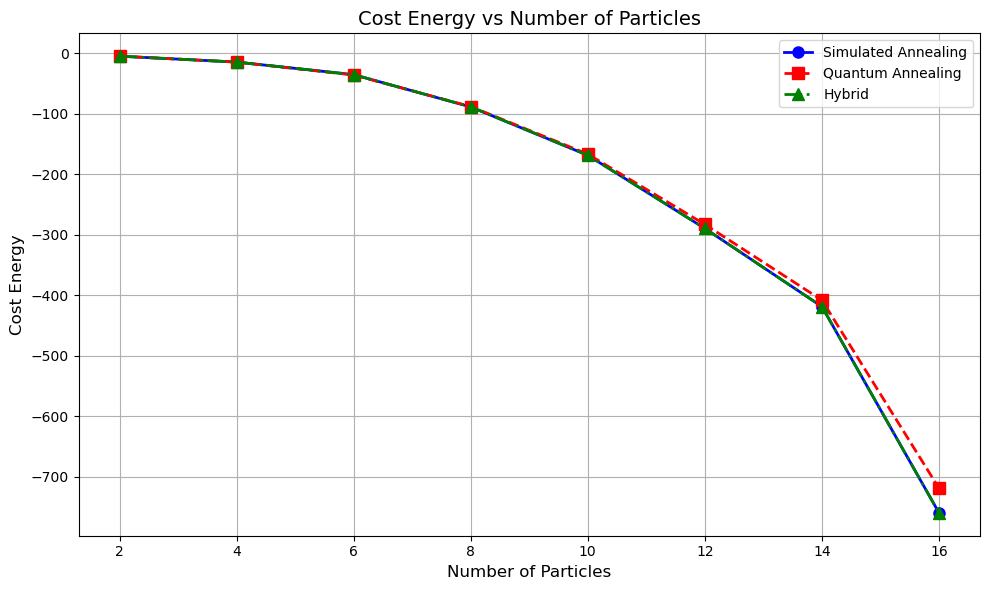

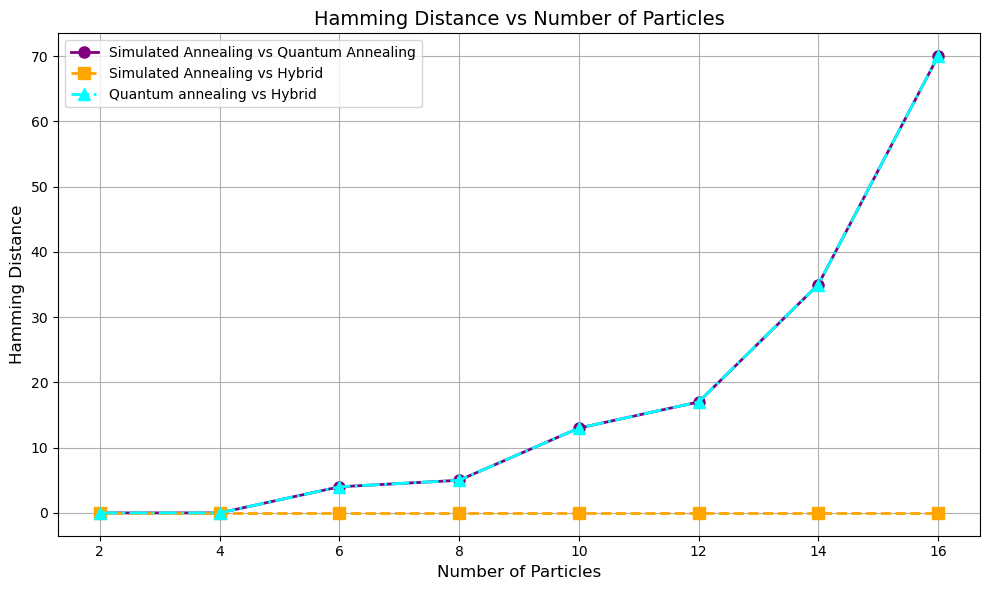

In [49]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt

# Assume the following functions are already defined:
# - generate_detector_hits(n_modules, n_particles)
# - generate_hamiltonian_optimized(event, params)
# - qubosolver(A, b)
# - qubosolverQA(A, b)
# - qubosolverHr(A, b)

# Define the problem sizes (number of particles)
particle_numbers = [2,4, 6, 8, 10, 12, 14, 16]
n_modules = 3  # Fixed number of modules

# Initialize lists to store results
hamming_distances = []
cost_energies = []

for n_particles in particle_numbers:
    # Calculate the size of the matrix (number of variables)
    N = n_particles ** 2 * (n_modules - 1)

    # Generate a random sparse symmetric matrix A with density 1%
    density = 0.01
    A_random = sp.random(N, N, density=density, format='coo', data_rvs=np.random.randn)
    A_upper = sp.triu(A_random)  # Keep upper triangular part
    A = A_upper + A_upper.T - sp.diags(A_upper.diagonal())  # Make symmetric
    A = A.tocsr()

    # Generate a random vector b
    b = np.random.randn(N)

    # Solve the QUBO problem using each solver
    x1 = qubosolver(A, b)
    x2_output = qubosolverQA(A, b)
    x3_output = qubosolverHr(A, b)

    # Extract sol_sample from the outputs
    if isinstance(x2_output, tuple):
        x2 = x2_output[0]  # Adjust the index if sol_sample is not the first element
    else:
        x2 = x2_output

    if isinstance(x3_output, tuple):
        x3 = x3_output[0]
    else:
        x3 = x3_output

    # Convert sol_sample lists to NumPy arrays
    x1 = np.array(x1)
    x2 = np.array(x2)
    x3 = np.array(x3)

    # Compute the cost energies
    E1 = x1.T @ (A @ x1) + b.T @ x1
    E2 = x2.T @ (A @ x2) + b.T @ x2
    E3 = x3.T @ (A @ x3) + b.T @ x3

    # Compute Hamming distances between the solutions
    hd12 = np.sum(x1 != x2)
    hd13 = np.sum(x1 != x3)
    hd23 = np.sum(x2 != x3)

    # Store the results
    hamming_distances.append([hd12, hd13, hd23])
    cost_energies.append([E1, E2, E3])

# Convert results to NumPy arrays for easier indexing
hamming_distances = np.array(hamming_distances)
cost_energies = np.array(cost_energies)

plt.figure(figsize=(10, 6))

plt.plot(particle_numbers, cost_energies[:, 0], label='Simulated Annealing',
         marker='o', linestyle='-', linewidth=2, markersize=8, color='blue')

plt.plot(particle_numbers, cost_energies[:, 1], label='Quantum Annealing',
         marker='s', linestyle='--', linewidth=2, markersize=8, color='red')

plt.plot(particle_numbers, cost_energies[:, 2], label='Hybrid',
         marker='^', linestyle='-.', linewidth=2, markersize=8, color='green')

plt.xlabel('Number of Particles', fontsize=12)
plt.ylabel('Cost Energy', fontsize=12)
plt.title('Cost Energy vs Number of Particles', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot the Hamming distances
plt.figure(figsize=(10, 6))

plt.plot(particle_numbers, hamming_distances[:, 0],
         label='Simulated Annealing vs Quantum Annealing', marker='o', linestyle='-',
         linewidth=2, markersize=8, color='purple')

plt.plot(particle_numbers, hamming_distances[:, 1],
         label='Simulated Annealing vs Hybrid', marker='s', linestyle='--',
         linewidth=2, markersize=8, color='orange')

plt.plot(particle_numbers, hamming_distances[:, 2],
         label='Quantum annealing vs Hybrid', marker='^', linestyle='-.',
         linewidth=2, markersize=8, color='cyan')

plt.xlabel('Number of Particles', fontsize=12)
plt.ylabel('Hamming Distance', fontsize=12)
plt.title('Hamming Distance vs Number of Particles', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()


In [10]:
from itertools import product
from scipy.sparse import csc_matrix

def brute_force(A, b):
    A = csc_matrix(A)
    n = len(b) 

    best_solution = None
    best_energy = np.inf
    for config in product([0, 1], repeat=n):
        config = np.array(config)
        #calculate energy: E = x^T A x + b^T x
        energy = config @ A @ config + b @ config
        if energy < best_energy:
            best_energy = energy
            best_solution = config

    print(f"Best Solution: {best_solution}")
    print(f"Best Energy: {best_energy}")

    return best_solution


brute_force_solution = brute_force(A, b)
print(f"Brute Force Solution: {brute_force_solution}")




Best Solution: [1 0 0 1 1 0 0 1 1 0 0 1 1 0 0 1]
Best Energy: -24.0
Brute Force Solution: [1 0 0 1 1 0 0 1 1 0 0 1 1 0 0 1]


Solution: [0 0 0 1 0 0 0 0 0 0]
Solution: [1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0]
Solution: [0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0]


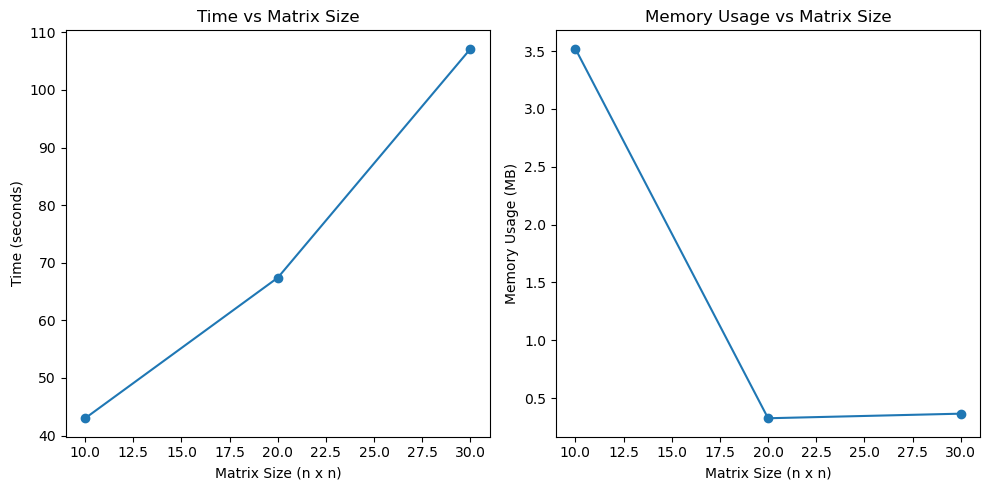

{'sizes': [10, 20, 30],
 'times': [43.00450780009851, 67.41154929995537, 107.14799750014208],
 'memory_usages': [3.520193099975586, 0.32555103302001953, 0.3651723861694336]}

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import tracemalloc
import time
from scipy.sparse import random as sparse_random, csc_matrix
from dimod import SimulatedAnnealingSampler, BinaryQuadraticModel

# Define the qubosolver function with tracemalloc for precise memory tracking


def generate_sparse_binary_matrix(size, density=0.01):
    """Generate a sparse binary matrix of given size with specified density."""
    return sp.random(size, size, density=density, format='csr', dtype=np.int8).astype(bool)

def qubosolver(A, b):
    A = csc_matrix(A)
    bqm = BinaryQuadraticModel.empty(dimod.BINARY)

    bqm.add_variables_from({i: b[i] for i in range(len(b))})

    row, col = A.nonzero()  
    for i, j in zip(row, col):
        if i != j:  
            bqm.add_interaction(i, j, A[i, j])

    sampler = SimulatedAnnealingSampler()
    response = sampler.sample(bqm, num_reads=100)

    best_sample = response.first.sample
    sol_sample = np.fromiter(best_sample.values(), dtype=int)  



    print(f"Solution: {sol_sample}")

    return sol_sample

    
def qubosolver_scalability_test(qubosolver, sizes):

    times = []
    memory_usages = []
    
    try:
        for size in sizes:
            A = generate_sparse_binary_matrix(size)
            b = np.random.randint(2, size=size).astype(np.int8)
            tracemalloc.start()
            start_time = time.perf_counter()
            
            qubosolver(A, b)
            
            # Calculate time and memory
            end_time = time.perf_counter()
            current, peak = tracemalloc.get_traced_memory()
            
            times.append(end_time - start_time)
            memory_usages.append(peak / 1024 ** 2)  # Convert bytes to MB
            
            tracemalloc.stop()
    
    except KeyboardInterrupt:
        print("Process interrupted by user. Plotting collected results...")
    except Exception as e:
        print(f"An error occurred: {e}. Plotting collected results...")
    finally:
        # Plotting results collected so far
        plt.figure(figsize=(10, 5))

        # Plot time vs matrix size
        plt.subplot(1, 2, 1)
        plt.plot(sizes[:len(times)], times, marker='o')
        plt.xlabel('Matrix Size (n x n)')
        plt.ylabel('Time (seconds)')
        plt.title('Time vs Matrix Size')

        # Plot memory usage vs matrix size
        plt.subplot(1, 2, 2)
        plt.plot(sizes[:len(memory_usages)], memory_usages, marker='o')
        plt.xlabel('Matrix Size (n x n)')
        plt.ylabel('Memory Usage (MB)')
        plt.title('Memory Usage vs Matrix Size')

        plt.tight_layout()
        plt.show()
        
    return {'sizes': sizes[:len(times)], 'times': times, 'memory_usages': memory_usages}

#sizes = [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1500, 2000, 5000, 8000, 10000]# Define sizes for scalability test
sizes= [10, 20 , 30]
qubosolver_scalability_test(qubosolver, sizes)
